In [139]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [140]:
import numpy as np
from tools import *
from fitters import *
from plots import *
set_seaborn()


In [141]:
noise = 1e-6
beta = 0
e_s = np.array([1.5, -0.8, -0.15])
a_s = np.array([0.01, 1.0, 0.2])
dim = 9
dt = 0.1
time = np.arange(0, 3+dt, dt)
N = len(time)
true_eigs = np.sort(np.exp(e_s*dt))[::-1]
noise_cartoon_factor = 2e4  # used to make noise look bigger for display purposes

# build X_series

components = []
for i in range(len(e_s)):
    c = exp_f(time, e_s[i], a_s[i])
    components.append(c)
X_series = np.sum(components, axis=0)


# build Y_series
Y_series = components[np.argmax(e_s)]
Y_series = Y_series[dim:]


In [142]:
# ALGO
noise_draws = 1000
thetas, preds = [], []
for _ in range(noise_draws):
    noise_series = noise * np.random.randn(N)
    X_series_noise = X_series + noise_series
    Xhan = build_hankel(X_series_noise, dim)
    X0 = Xhan[:, :-1]
    Xp = Xhan[:, 1:]
    lam = beta * np.eye(dim)
    X0Xp = X0 @ Xp.T
    X0X0 = X0 @ X0.T
    # solve eigenvalue problem
    w, vl = scipy.linalg.eig(X0Xp, (X0X0+lam))

    theta = vl[:, np.nanargmax(np.abs(w))]
    w = np.sort(np.real_if_close(w))[::-1]

    theta /= theta[-1]
    pred_series = theta.real @ Xhan
    pred_series /= pred_series[0]/Y_series[0]
    thetas.append(theta.real)
    preds.append(pred_series)

theta = np.mean(thetas, axis=0)
pred_series = np.mean(preds, axis=0)


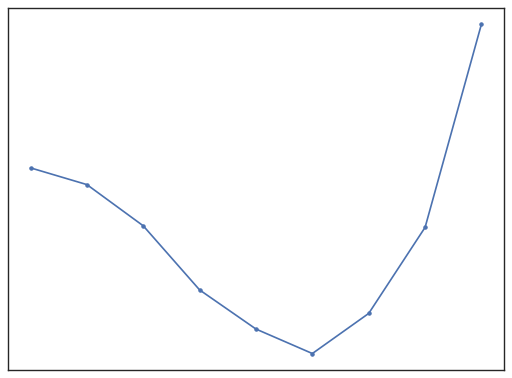

In [143]:
plt.plot(np.arange((-len(theta)+1)*dt,dt, dt), theta.real, '.-');
plt.xticks([]); plt.yticks([]); 
plt.show()

In [144]:
ylims = [-0.1,1.3]

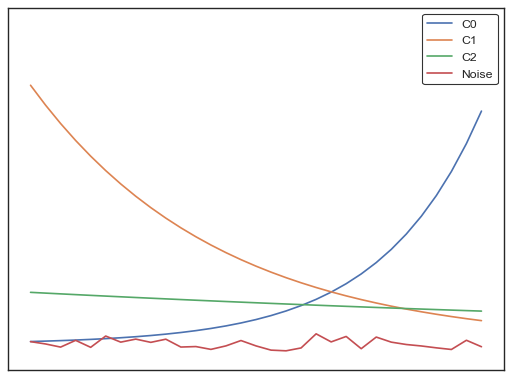

In [145]:
[plt.plot(time, c, label=f'C{i}') for i,c in enumerate(components)]
plt.plot(time, noise_series*noise_cartoon_factor, label='Noise')
plt.ylim(ylims)
plt.legend()
plt.xticks([]); plt.yticks([]); 
plt.show()

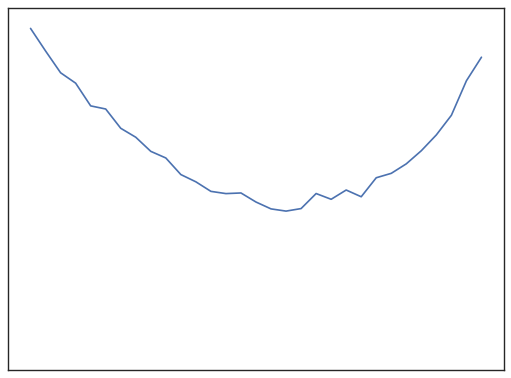

In [146]:
plt.plot(time, X_series +(noise_series*noise_cartoon_factor));
plt.ylim(ylims)
plt.xticks([]); plt.yticks([]); 
plt.show()

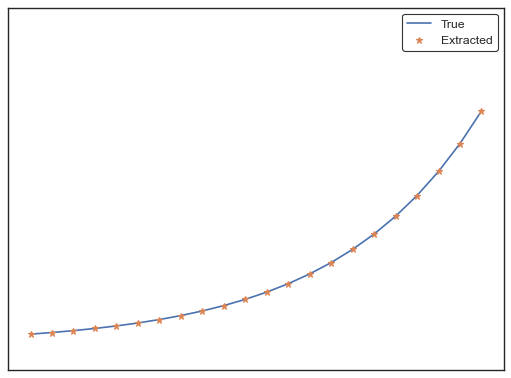

In [147]:
plt.plot(time[dim:], Y_series, label='True');
plt.plot(time[dim:], pred_series, '*', label='Extracted');
plt.legend()
plt.ylim(ylims)
plt.xticks([]); plt.yticks([]); 
plt.show()

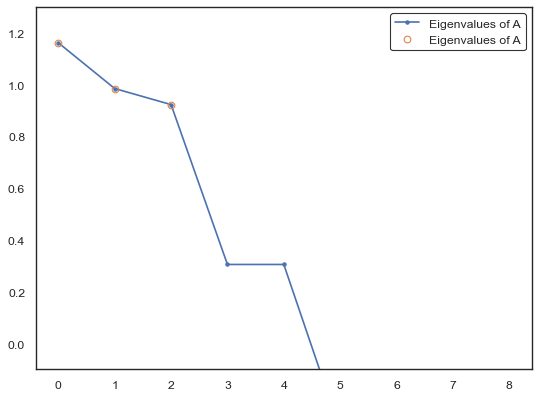

In [148]:
plt.plot(w.real, '.-', label='Eigenvalues of A');
plt.plot(true_eigs, 'o', fillstyle='none', label='Eigenvalues of A');
plt.legend()
plt.ylim(ylims)
plt.show()